# 1. Set Up Notebook and Load Data 

In [1]:
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import pandas as pd
import fnmatch
import pickle
import ipywidgets as widgets
from IPython.display import display
import sys
import os
import math
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
import tensorflow as tf 
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
# Check for TensorFlow GPU access
print(f"TensorFlow has access to the following devices:\n{tf.config.list_physical_devices()}")
# See TensorFlow version
print(f"TensorFlow version: {tf.__version__}")
import math
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, losses
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Reshape, Input, Flatten, Dense, Conv2DTranspose, LeakyReLU, BatchNormalization,  LeakyReLU,  Activation, LSTM, TimeDistributed, RepeatVector, Lambda
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers.legacy import Adam
from keras.activations import elu
from tensorflow.keras.initializers import HeUniform, GlorotUniform, HeNormal, LecunNormal
from keras.regularizers import l2, l1, Regularizer

# CUSTOM Imports
def list_folders_fun(path):
    """
    DESCRIPTION: List folders in a given directory.
    INPUT: Directory path
    OUTPUT: Folder names in a given directory
    """
    folder_list = [f.name for f in Path(path).iterdir() if f.is_dir()]
    return folder_list

# Specify global path
global_path = '/Users/steven/Library/Mobile Documents/com~apple~CloudDocs/0-CfA/4-Data/Datasets'
global_folders = list_folders_fun(global_path)

# Select dataset
set_widget = widgets.Dropdown(options=global_folders[:],value=global_folders[0],description='Set :',disabled=False); set_widget

Num GPUs Available:  1
TensorFlow has access to the following devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow version: 2.12.0


Dropdown(description='Set :', options=('Full', 'All', 'Full_extra', 'New', 'Bona'), value='Full')

In [2]:
# Set ID
set_id = set_widget.value
# Select Input
files = os.listdir(f'{global_path}/{set_id}/')
input_files = [f for f in files if fnmatch.fnmatch(f, 'hist2D*24*none*')]
input_widget = widgets.Dropdown(options=input_files[:],value=input_files[0],description='TSNE File :',disabled=False); input_widget

Dropdown(description='TSNE File :', options=('hist2D-Full-nE16-nt24-normnone.pkl',), value='hist2D-Full-nE16-n…

In [15]:
# Load features
input_file = input_widget.value
with open(f'{global_path}/{set_id}/{input_file}', 'rb') as f:
    hist_dict = pickle.load(f)
ids = list(hist_dict.keys())
histograms = hist_dict.values()
features = np.array([np.array(h) for h in histograms])
# Load properties
df_properties_input = pd.read_csv(f'{global_path}/{set_id}/properties-input-Full.csv')
df_properties_input = df_properties_input[df_properties_input['obsreg_id'].isin(list(ids))]
df_properties = df_properties_input.drop_duplicates('obsreg_id', keep='first').reset_index(drop=True)
df_eventfiles_input = pd.read_csv(f'{global_path}/{set_id}/eventfiles-input-{set_id}.csv')
df_properties_global = pd.read_csv(f'{global_path}/{set_id}/properties-{set_id}.csv')
df_properties_global['obsreg_id'] = df_properties_global['obsid'].astype(str) + '_' + df_properties_global['region_id'].astype(str)
df_eventfiles_group = df_eventfiles_input.groupby('obsreg_id')
df_properties_group = df_properties_input.groupby('obsreg_id')
# Data
df_label = df_properties.copy()
ID = df_label['obsreg_id'].values

num_samples = features.shape[0]
flattened_features = features.reshape(num_samples, -1) 
scaled_features = StandardScaler().fit_transform(flattened_features)
features = scaled_features.reshape(num_samples, 24, 16)

X = features
X_train, X_test, ID_train, ID_test = train_test_split(X, ID, test_size=0.1, random_state=505)
# Print Summary
print ('Training Set', X_train.shape)
print ('Test Set', X_test.shape)
print("Number of Features: ", len(features))
print("Number of Property Sets: ", len(df_properties))

df_label.head()

Training Set (85925, 24, 16)
Test Set (9548, 24, 16)
Number of Features:  95473
Number of Property Sets:  95473


,name,obsreg_id,hard_hm,hard_hs,hard_ms,var_prob_b,var_prob_h,var_prob_m,var_prob_s,var_index_b
0,2CXO J173522.0-260053,10037_123,0.354778,0.782011,0.540912,0.077612,0.092974,0.756124,NaN,0.0
1,2CXO J173403.7-260619,10037_30,0.564647,0.999375,0.999375,0.475838,0.436236,0.488032,NaN,0.0
2,2CXO J173412.7-260548,10037_40,0.033729,0.343535,0.312305,0.119011,0.438140,0.236688,0.551795,0.0
3,2CXO J173416.8-260131,10037_79,0.352280,0.801999,0.610868,0.135159,0.314770,0.834953,NaN,0.0
4,2CXO J173426.3-255911,10037_81,0.548407,0.999375,0.999375,0.299827,0.675399,0.370636,NaN,0.0


# 3. Automodel Model

In [114]:
# Custom callback to update the learning rate
class StepDecayScheduler(tf.keras.callbacks.Callback):
    def __init__(self, initial_lr, decay_steps, decay_rate):
        super(StepDecayScheduler, self).__init__()
        self.initial_lr = initial_lr
        self.decay_steps = decay_steps
        self.decay_rate = decay_rate

    def on_epoch_begin(self, epoch, logs=None):
        updated_lr = self.initial_lr * (self.decay_rate ** (epoch // self.decay_steps))
        tf.keras.backend.set_value(self.model.optimizer.lr, updated_lr)
        print(f"Learning rate for epoch {epoch+1}: {updated_lr}")



In [44]:
input_shape = (24, 16)
in1 = 24
in2 = 16
activation = 'linear' #LeakyReLU(alpha=0.1) # 'selu' # LeakyReLU(alpha=0.2)
kernel_init = 'glorot_uniform' #HeUniform(seed=505) # 'he_normal' #'glorot_uniform' #HeNormal(seed=505) #glorot_uniform' #'he_normal' #'glorot_uniform'
encoder_dims = []   
decoder_dims = encoder_dims[::-1]
bottleneck = 15
# Define encoder
model = Sequential()
model.add(Flatten(input_shape=input_shape))
for dim in encoder_dims:
    model.add(Dense(dim, activation=activation))
# Define bottleneck
model.add(Dense(bottleneck, activation=activation, name='bottleneck'))
# Define decoder
for dim in decoder_dims:
    model.add(Dense(dim, activation=activation))
model.add(Dense(in1*in2,activation='linear'))
model.add(Reshape((in1,in2)))
model.summary()
# Training Set Up
name = input('Name: ')
print(name)
epochs = 200
batch = 512
lr = 0.0005
early_stopping = EarlyStopping(monitor='val_loss', patience=25, verbose=1, restore_best_weights=True)
loss_function = 'mse'
reduce_lr_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.0000001)
optimizer = Adam(learning_rate = lr)
model.compile(optimizer=optimizer, loss=loss_function)
# Define a callback function to display the learning rate for each epoch
bottle_index = model.layers.index(model.get_layer(name='bottleneck'))
print('Depth: ', bottle_index)
history = model.fit(X_train, X_train, epochs=epochs,batch_size=batch,shuffle=True,validation_split=0.2,callbacks=[reduce_lr_callback , early_stopping]) # 128 or 256, 512, 1024, 2048, 4096
encoder_model = Model(inputs=model.input, outputs=model.layers[bottle_index].output)
# Saving
model.save(f'{global_path}/{set_id}/XAE-AUTOENCODER-2D-PCA{bottleneck}-fc{encoder_dims}-lr{lr}-e{epochs}-b{batch}-{name}.h5')
encoder_model.save(f'{global_path}/{set_id}/XAE-ENCODER-2D-PCA{bottleneck}-fc{encoder_dims}-lr{lr}-e{epochs}-b{batch}-{name}.h5')
with open(f'{global_path}/{set_id}/XAE-HISTORY-2D-PCA{bottleneck}-fc{encoder_dims}-lr{lr}-e{epochs}-b{batch}-{name}.pickle', 'wb') as file:
    pickle.dump(history.history, file)



Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 384)               0         
                                                                 
 bottleneck (Dense)          (None, 15)                5775      
                                                                 
 dense_4 (Dense)             (None, 384)               6144      
                                                                 
 reshape_4 (Reshape)         (None, 24, 16)            0         
                                                                 
Total params: 11,919
Trainable params: 11,919
Non-trainable params: 0
_________________________________________________________________

Depth:  1
Epoch 1/200
135/135 [==============================] - 1s 7ms/step - loss: 0.7831 - val_loss: 0.2487 - lr: 5.0000e-04
Epoch 2/200
135/135 [==============================] 

KeyboardInterrupt: 

In [45]:
# Select saved model
files = os.listdir(f'{global_path}/{set_id}/')
ac_files = [f for f in files if fnmatch.fnmatch(f, '*-AUTOENCODER*PCA*fc[*h5')]
encode_files = [f for f in files if fnmatch.fnmatch(f, '*-ENCODER*PCA*fc[*h5')]
hist_files = [f for f in files if fnmatch.fnmatch(f, '*-HISTORY*PCA*fc[*pickle')]
ac_widget = widgets.Dropdown(options=ac_files[:],value=ac_files[-1],description='Autoencoder :',disabled=False,style = {'description_width': 'initial'}); ac_widget 
hist_widget = widgets.Dropdown(options=hist_files[:],value=hist_files[-1],description='History :',disabled=False,style = {'description_width': 'initial'}); hist_widget 
encode_widget = widgets.Dropdown(options=encode_files[:],value=encode_files[-1],description='Encoder :',disabled=False,style = {'description_width': 'initial'}); encode_widget 
layout = widgets.HBox([ac_widget, hist_widget, encode_widget])
display(layout)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 384)               0         
                                                                 
 bottleneck (Dense)          (None, 15)                5775      
                                                                 
 dense_3 (Dense)             (None, 384)               6144      
                                                                 
 reshape_3 (Reshape)         (None, 24, 16)            0         
                                                                 
Total params: 11,919
Trainable params: 11,919
Non-trainable params: 0
_________________________________________________________________
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3_input (InputLayer  [(N

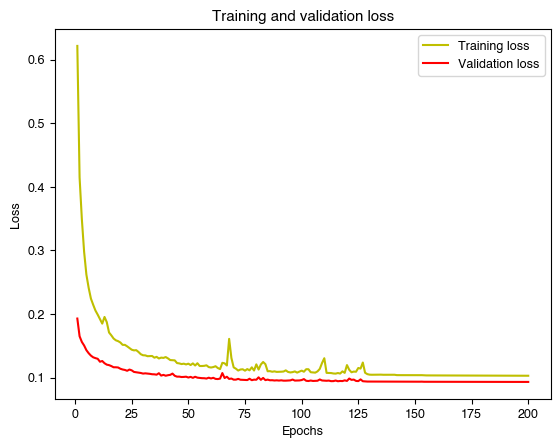

In [46]:
# Load the selected saved model 
ac = ac_widget.value
h = hist_widget.value
e = encode_widget.value
model = tf.keras.models.load_model(f'{global_path}/{set_id}/{ac}')
encoder_model = tf.keras.models.load_model(f'{global_path}/{set_id}/{e}')
model.summary()
encoder_model.summary()
with open(f'{global_path}/{set_id}/{h}', 'rb') as file:
    summary = pickle.load(file)
#plot the training and validation accuracy and loss at each epoch
loss = summary['loss']
val_loss = summary['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [47]:
test_loss = model.evaluate(X_test, X_test)

# Print the test loss
print(f'Test loss: {test_loss:.4f}') #0.0088 yuri

299/299 [==============================] - 1s 3ms/step - loss: 0.1126
Test loss: 0.1126


In [48]:
reconstructions = model.predict(X)
embedding = encoder_model.predict(X)

2984/2984 [==============================] - 2s 776us/step


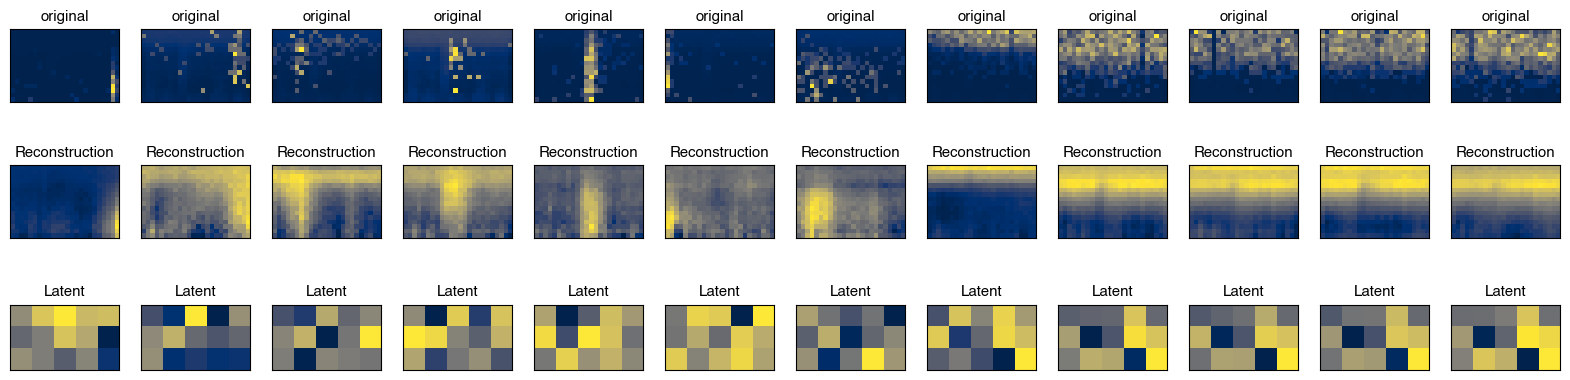

In [50]:
import random
# filtered_ids = [id for id in ids if id.split('_')[1] == '10'][10:20]
#####SELECTED ANOMALIES
flares_maybe = ['10542_331','10556_6687','10556_5752','10556_6687']
dips_maybe = ['13814_586','13813_218']
# DIPS ET AL
parmar = ['10783_10','10871_10','11059_10','9070_10'] # LMXB dips!
distefano = ['13814_567']
m101ulx = ['4736_81','6170_74','4733_229','4737_74','5300_95','5322_229','6152_81']
ieva = ['11272_13','13812_586','13812_218','9550_17','942_101','6152_79']
# FLARES ET AL 
lin = ['4062_31', '13454_56','20635_58'] 
xue = ['957_208', '3389_274','15211_38']
irwin = ['3926_13','7800_4','7799_16','8490_30']
glennie = ['12884_10']
jonker = ['803_90']
vasquez = ['2025_39','9546_17','9548_14','12264_54','15113_59']
vasquez = ['2025_39','9548_14','15113_59']
nandra = ['9875_166', '9456_274', '5849_62']
goulding =['8636_2', '8636_3'] # last one not listed 2012 2015
flares = ['4395_992','16444_1025','13637_1078','14368_489','14368_503','10822_185','10955_21','10996_5','2833_53','13610_112','15214_29','1042_24']
NEW = ['23022_122']
ran = random.randint(0, 95000)
r = ids[ran:ran+10]
items_to_find = NEW + xue + lin + distefano + parmar 
# items_to_find = r
# Using a list comprehension to find indices of items in the other list
indices = [ids.index(item) for item in items_to_find]

n = len(indices)
plt.figure(figsize=(20, 5))
top = 40
k = 0 

for i in indices:
  k = k+1
  # display original
  ax = plt.subplot(3, n, k)
  plt.imshow(X[i].T,cmap='cividis')
  plt.title("original")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(3, n, k+n)
  plt.imshow(reconstructions[i].T,cmap='cividis')
  plt.title(f'Reconstruction')
  # plt.title(f'R: {rec_err[i]:.3f}')
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display encoded results
  ax = plt.subplot(3, n, k+n+n)
  plt.imshow(embedding[i].reshape((5,3)).T,cmap='cividis')
  plt.title(f'Latent')
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

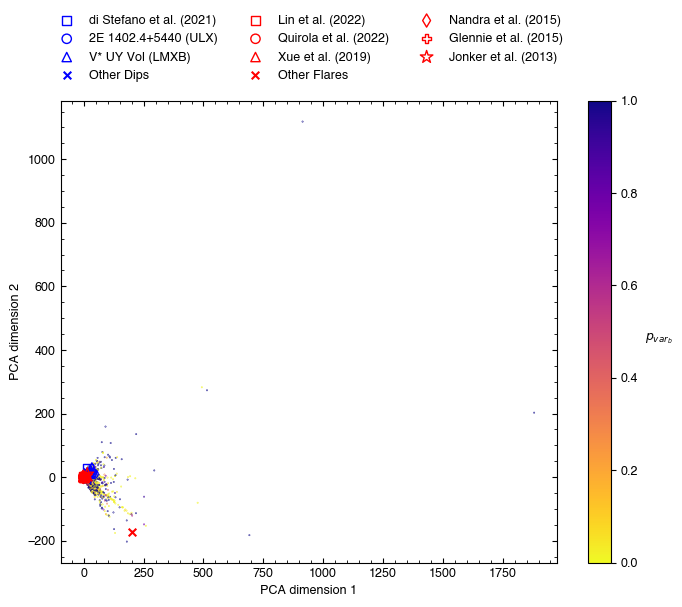

In [51]:
# PCA
from sklearn.decomposition import PCA
pca_model = PCA(2)
X_pca = pca_model.fit_transform(embedding) 
df_pca = pd.DataFrame(X_pca, columns=['1', '2'])
df_pca['obsreg_id'] = ID

pca_lin = df_pca.loc[df_pca['obsreg_id'].isin(lin)]
pca_irwin = df_pca.loc[df_pca['obsreg_id'].isin(irwin)]
pca_glennie = df_pca.loc[df_pca['obsreg_id'].isin(glennie)]
pca_jonker = df_pca.loc[df_pca['obsreg_id'].isin(jonker)]
pca_vasquez = df_pca.loc[df_pca['obsreg_id'].isin(vasquez)]
pca_xue = df_pca.loc[df_pca['obsreg_id'].isin(xue)]
pca_goulding = df_pca.loc[df_pca['obsreg_id'].isin(goulding)]
pca_nandra = df_pca.loc[df_pca['obsreg_id'].isin(nandra)]
pca_flares = df_pca.loc[df_pca['obsreg_id'].isin(flares + flares_maybe)]

pca_m101ulx = df_pca.loc[df_pca['obsreg_id'].isin(m101ulx)]
pca_distefano = df_pca.loc[df_pca['obsreg_id'].isin(distefano)]
pca_moredips = df_pca.loc[df_pca['obsreg_id'].isin(ieva + dips_maybe)]
pca_parmar = df_pca.loc[df_pca['obsreg_id'].isin(parmar)] # LMXB

pca_new = df_pca.loc[df_pca['obsreg_id'].isin(NEW)] 

fig, axs = plt.subplots(figsize=(8, 6))
var_b = axs.scatter(df_pca['1'], df_pca['2'],c=df_label['var_prob_b'], s=0.1, cmap='plasma_r')
axs.set_xlabel('PCA dimension 1')
axs.set_ylabel('PCA dimension 2')
axs.grid(False) 
cbar = axs.figure.colorbar(var_b, ax=axs)
cbar.ax.set_ylabel(r'$p_{var_b}$', rotation = 0,labelpad=15)
axs.minorticks_on()
axs.tick_params(which='both', direction='in', top=True, right=True)

c_d = 'blue'
c_f = 'red'
markersize = 30

axs.scatter(pca_distefano['1'], pca_distefano['2'], edgecolors=c_d, marker='s', s=markersize*1.5, facecolor='none', label='di Stefano et al. (2021)')
axs.scatter(pca_m101ulx['1'], pca_m101ulx['2'], edgecolors=c_d, marker='o', s=markersize*1.5, facecolor='none', label='2E 1402.4+5440 (ULX)')
axs.scatter(pca_parmar['1'], pca_parmar['2'], edgecolors=c_d, marker='^', s=markersize*1.5, facecolor='none', label='V* UY Vol (LMXB)')
axs.scatter(pca_moredips['1'], pca_moredips['2'], c=c_d, marker='x', s=markersize*1, facecolor='none', label='Other Dips')
 
axs.scatter(pca_lin['1'], pca_lin['2'], edgecolors=c_f, marker='s', s=markersize*1.5, facecolor='none', label='Lin et al. (2022)')
axs.scatter(pca_vasquez['1'], pca_vasquez['2'], edgecolors=c_f, marker='o', s=markersize*1.5, facecolors='none', label='Quirola et al. (2022)')
axs.scatter(pca_xue['1'], pca_xue['2'], edgecolors=c_f, marker='^', s=markersize*1.5, facecolor='none', label='Xue et al. (2019)')
axs.scatter(pca_flares['1'], pca_flares['2'], c=c_f, marker='x', s=markersize*1, facecolor='none', label='Other Flares')
axs.scatter(pca_nandra['1'], pca_nandra['2'], edgecolors=c_f, marker='d', s=markersize*1.5, facecolor='none', label='Nandra et al. (2015)')
axs.scatter(pca_glennie['1'], pca_glennie['2'], edgecolors=c_f, marker='P', s=markersize*1.5, facecolor='none', label='Glennie et al. (2015)')
axs.scatter(pca_jonker['1'], pca_jonker['2'], edgecolors=c_f, marker='*', s=markersize*3, facecolor='none', label='Jonker et al. (2013)')

# axs.scatter(pca_new['1'], pca_new['2'], c='magenta', marker='X', s=markersize*5, facecolor='none', label='NEW')

axs.grid(False) 
axs.minorticks_on()
axs.tick_params(which='both', direction='in', top=True, right=True)
anomaly_legend = axs.legend(loc='upper center', bbox_to_anchor=(0.5, 1.21),
          ncol=3, frameon = False,fontsize=9)

500 -300


Text(0, 0.5, 'tSNE feature 2')

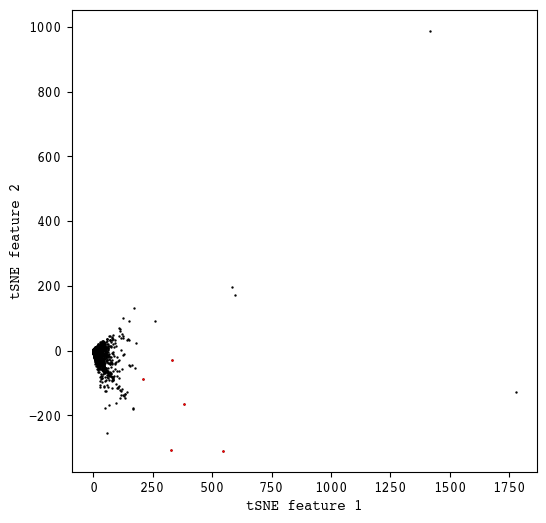

In [36]:
box_size = 300

# box = anomalies[anomalies['obsreg_id']=='17743_278']
box = df_pca[df_pca['obsreg_id']=='23022_122'] #'10783_10','10871_10','11059_10','9070_10' distefano = ['13814_567'] NEW = ['23022_122']
x0, y0 = box[['1']].values[0][0], box[['2']].values[0][0]
x0, y0 = 500,-300
print(x0, y0)
xmin, xmax = x0 - box_size, x0 + box_size
ymin, ymax = y0 - box_size, y0 + box_size
points_in_box = df_pca[(df_pca['1'] >= xmin) & (df_pca['1'] <= xmax) & (df_pca['2'] >= ymin) & (df_pca['2'] <= ymax)]
potential_anomalies2 = points_in_box['obsreg_id']
df_properties_anomalies2 = df_properties_global[df_properties_global['obsreg_id'].isin(potential_anomalies2)]

fig, axs = plt.subplots(1, 1, figsize=(6, 6))
plt.rcParams.update({'font.size': 10})
plt.rcParams['font.monospace'] = "Courier"
plt.rcParams["font.family"] = "monospace"
rej = axs.scatter(df_pca['1'], df_pca['2'], s=0.5, c='black', label = 'Rejected Clusters')
acc = axs.scatter(points_in_box['1'], points_in_box['2'], s=0.5, c='red', label = 'Chosen Clusters')
axs.set_xlabel('tSNE feature 1')
axs.set_ylabel('tSNE feature 2')

In [32]:
# 6. Lightcurve Plotter Function
import astropy 
from astropy import stats as astats
def lightcurveplotterNEW(df_eventfiles_input,id_name,bin_size_sec,hr_window=10,bb_p0 = 0.1,band_errors = True):
    """
    DESCRIPTION: Plots lightcurves and cumulative counts for given eventfile input dataframe
    INPUT: 1. Original eventfile table, 2. Original properties table, 3. Global Path, 4. Set Name
    OUTPUT: 1. Reduced eventfile table, 2. Reduced properties table
    """
    # Define Colour Scheme
    google_blue = '#4285F4'
    google_red = '#DB4437'
    google_yellow = '#F4B400'
    google_green = '#0F9D58'
    google_purple = '#6f2da8'
    # Define Font Settings
    plt.rcParams.update({'font.size': 9})
    plt.rcParams['font.sans-serif'] = 'Helvetica'
    plt.rcParams['font.family'] = 'sans-serif'
    # Create subplots 
    fig, axs = plt.subplots(5, 1, figsize=(6, 12),constrained_layout = True)
    fig.suptitle(f'ObsRegID: {id_name}',fontweight="bold")
    # Prepare df
    df = df_eventfiles_input.copy()
    df['time'] = df_eventfiles_input['time'] - min(df_eventfiles_input['time'])
    df = df.sort_values(by='time') 
    df = df.reset_index(drop=True)
    # Create binned lightcurve
    df_binned = df.groupby(df['time'] // bin_size_sec * bin_size_sec).agg(
        broad_count = ('energy', lambda x: ((x >= 500) & (x <= 7000)).sum()),
        soft_count =('energy', lambda x: ((x >= 500) & (x < 1200)).sum()),
        medium_count=('energy', lambda x: ((x >= 1200) & (x < 2000)).sum()),
        hard_count=('energy', lambda x: ((x >= 2000) & (x <= 7000)).sum()))
    # Plot binned lightcurve
    axs[0].plot(df_binned.index/1000, df_binned['broad_count'], color = google_blue, marker = 'o', markerfacecolor = 'black', markersize = 4)
    axs[0].set_xlabel('Time [ks]')
    axs[0].set_ylabel('Counts per Bin')
    axs[0].set_title(f'Lightcurve with {bin_size_sec}s Bin Size')
    axs[0].set_xlim([0,max(df["time"]/1000)])
    # Create rolling 3-bin averaged lightcurved
    df_rolling = df_binned.rolling(window=3, center=True).mean()
    rolling_std = df_binned.rolling(window=3, center=True).std()
    errors = rolling_std['broad_count']/math.sqrt(3)
    errors.iloc[0] = errors.iloc[0] * math.sqrt(3)/math.sqrt(2)
    errors.iloc[-1] = errors.iloc[-1] * math.sqrt(3)/math.sqrt(2)

    errors_h = rolling_std['hard_count']/math.sqrt(3)
    errors_h.iloc[0] = errors_h.iloc[0] * math.sqrt(3)/math.sqrt(2)
    errors_h.iloc[-1] = errors_h.iloc[-1] * math.sqrt(3)/math.sqrt(2)

    errors_m = rolling_std['medium_count']/math.sqrt(3)
    errors_m.iloc[0] = errors_m.iloc[0] * math.sqrt(3)/math.sqrt(2)
    errors_m.iloc[-1] = errors_m.iloc[-1] * math.sqrt(3)/math.sqrt(2)

    errors_s = rolling_std['soft_count']/math.sqrt(3)
    errors_s.iloc[0] = errors_s.iloc[0] * math.sqrt(3)/math.sqrt(2)
    errors_s.iloc[-1] = errors_s.iloc[-1] * math.sqrt(3)/math.sqrt(2)
    # Plot rolling 3-bin averaged lightcurved
    axs[1].plot(df_rolling.index/1000, df_rolling['broad_count'], color = google_red)
    axs[1].errorbar(df_rolling.index/1000, df_rolling['broad_count'], yerr = errors, xerr = None,fmt ='.',color = "black",linewidth = .5,capsize = 1)
    axs[1].set_xlabel('Time [ks]')
    axs[1].set_ylabel('Counts per Bin')
    axs[1].set_title('Running Average of 3 Bins')
    axs[1].set_xlim([0,max(df["time"]/1000)])
    # Create cumulative count plot
    df_cumulative = df.copy()
    df_cumulative['count'] = 1
    df_cumulative['cumulative_count'] = df_cumulative['count'].cumsum()
    # Create a BB plot
    bb_bins = astats.bayesian_blocks(df['time'].values/1000, fitness='events',p0 = bb_p0) # p0 = 0.01 or so BASED ON VINAY ! 6?
    bin_widths = bb_bins[1:] - bb_bins[:-1]
    counts, bins =  np.histogram(df['time']/1000, bins=bb_bins)
    countrate = counts/bin_widths 
    bin_centers = (bb_bins[:-1] + bb_bins[1:]) / 2
    axs[3].step(bb_bins, np.append(countrate, countrate[-1]), where='post', color='black')
    axs[3].set_xlim([0,max(df["time"]/1000)])
    # axs[3].set_xlim(axs[1].get_xlim())
    axs[3].set_xlabel('Time [ks]')
    axs[3].set_ylabel('Count Rate')
    axs[3].set_title(f'Bayesian Blocks Count Rate (p0 = {bb_p0})')
    # Create a Energy Band Plot
    axs[2].plot(df_rolling.index/1000, df_rolling['hard_count'], color = google_blue, label='Hard')
    axs[2].plot(df_rolling.index/1000, df_rolling['medium_count'], color = google_green, label='Medium')
    axs[2].plot(df_rolling.index/1000, df_rolling['soft_count'], color = google_red, label='Soft')
    if band_errors == True:
        axs[2].errorbar(df_rolling.index/1000, df_rolling['hard_count'], yerr = errors_h, xerr = None,fmt ='.',color = google_blue,linewidth = 1,capsize = 2)
        axs[2].errorbar(df_rolling.index/1000, df_rolling['medium_count'], yerr = errors_m, xerr = None,fmt ='.',color = google_green,linewidth = 1,capsize = 2)
        axs[2].errorbar(df_rolling.index/1000, df_rolling['soft_count'], yerr = errors_s, xerr = None,fmt ='.',color = google_red,linewidth = 1,capsize = 2)
    axs[2].set_xlim([0,max(df_binned.index/1000)])
    # axs[3].set_ylim([0,np.max([df_binned['hard_count'],df_binned['medium_count'],df_binned['soft_count']])*1.3])
    axs[2].set_ylabel('Counts')
    axs[2].set_xlabel('Time [ks]')
    axs[2].set_title(f'Energy Bands with {bin_size_sec}s Bin Size - Running Avg')
    axs[2].legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),ncol=3, frameon = False)

    # # Create HR 
    # # Compute the counts for each energy band
    # df['soft_count'] = ((df['energy'] >= 500) & (df['energy'] < 1200)).rolling(hr_window).sum()
    # df['medium_count'] = ((df['energy'] >= 1200) & (df['energy'] < 2000)).rolling(hr_window).sum()
    # df['hard_count'] = ((df['energy'] >= 2000) & (df['energy'] <= 7000)).rolling(hr_window).sum()
    # df[['soft_count', 'medium_count','hard_count']] = df[['soft_count', 'medium_count','hard_count']].shift(-math.floor(hr_window/2))
    # # Compute the HR ratios using the counts
    # df['HR_hs'] = (df['hard_count'] - df['soft_count']) / (df['hard_count'] + df['soft_count'])
    # df['HR_hm'] = (df['hard_count'] - df['medium_count']) / (df['hard_count'] + df['medium_count'])
    # df['HR_ms'] = (df['medium_count'] - df['soft_count']) / (df['medium_count'] + df['soft_count'])

    # axs[4].plot(df["time"]/1000, df['HR_hs'], color = google_blue, label='H-S')
    # axs[4].plot(df["time"]/1000, df['HR_hm'], color = google_green, label='H-M')
    # axs[4].plot(df["time"]/1000, df['HR_ms'], color = google_red, label='M-S')
    # axs[4].set_xlim([0,max(df["time"]/1000)])
    # # axs[3].set_ylim([0,np.max([df_binned['hard_count'],df_binned['medium_count'],df_binned['soft_count']])*1.3])
    # axs[4].set_ylabel('HR')
    # axs[4].set_xlabel('Time [ks]')
    # axs[4].set_title(f'Running HR over {hr_window} counts')
    # axs[4].legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),ncol=3, frameon = False)

    #Create BB HR
    df_hr_bb = df.copy()
    # compute photon counts in each bin
    df_hr_bb = df_hr_bb.groupby(pd.cut(df_hr_bb['time']/1000, bb_bins)).agg(
        hard_count=('energy', lambda x: ((x >= 2000) & (x <= 7000)).sum()),
        medium_count=('energy', lambda x: ((x >= 1200) & (x < 2000)).sum()),
        soft_count=('energy', lambda x: ((x >= 500) & (x < 1200)).sum())
    )
    df_hr_bb["bb_hs"] = (df_hr_bb['hard_count'] - df_hr_bb['soft_count']) / (df_hr_bb['hard_count'] + df_hr_bb['soft_count'])
    df_hr_bb["bb_hm"]  = (df_hr_bb['hard_count'] - df_hr_bb['medium_count']) / (df_hr_bb['hard_count'] + df_hr_bb['medium_count'])
    df_hr_bb["bb_ms"]  = (df_hr_bb['medium_count'] - df_hr_bb['soft_count']) / (df_hr_bb['medium_count'] + df_hr_bb['soft_count'])
    bb_hs = df_hr_bb["bb_hs"].values
    bb_hm = df_hr_bb["bb_hm"].values
    bb_ms = df_hr_bb["bb_ms"].values
    axs[4].step(bb_bins, np.append(bb_hs, bb_hs[-1]), where='post',color = google_blue, label='H-S')
    axs[4].step(bb_bins, np.append(bb_hm, bb_hm[-1]), where='post',color = google_green, label='H-M')
    axs[4].step(bb_bins, np.append(bb_ms, bb_ms[-1]), where='post',color = google_red, label='M-S')
    axs[4].set_xlim([0,max(df["time"]/1000)])
    # axs[5].set_xlim(axs[1].get_xlim())
    axs[4].set_ylabel('HR')
    axs[4].set_xlabel('Time [ks]')
    axs[4].set_title(f'Bayesian Blocks HR')
    axs[4].legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),ncol=3, frameon = False)
    plt.show()
    return countrate 

5
Name: 2CXO J053834.6-685306, ID: 18671-1182, Date: 2015-12-14T00:11:19, Counts: 30163
RA  84.64452641791729 DEC  -68.88515995257784
varB  1.0 varH  1.0 varM  1.0 varS  1.0 varINDEX  10.0


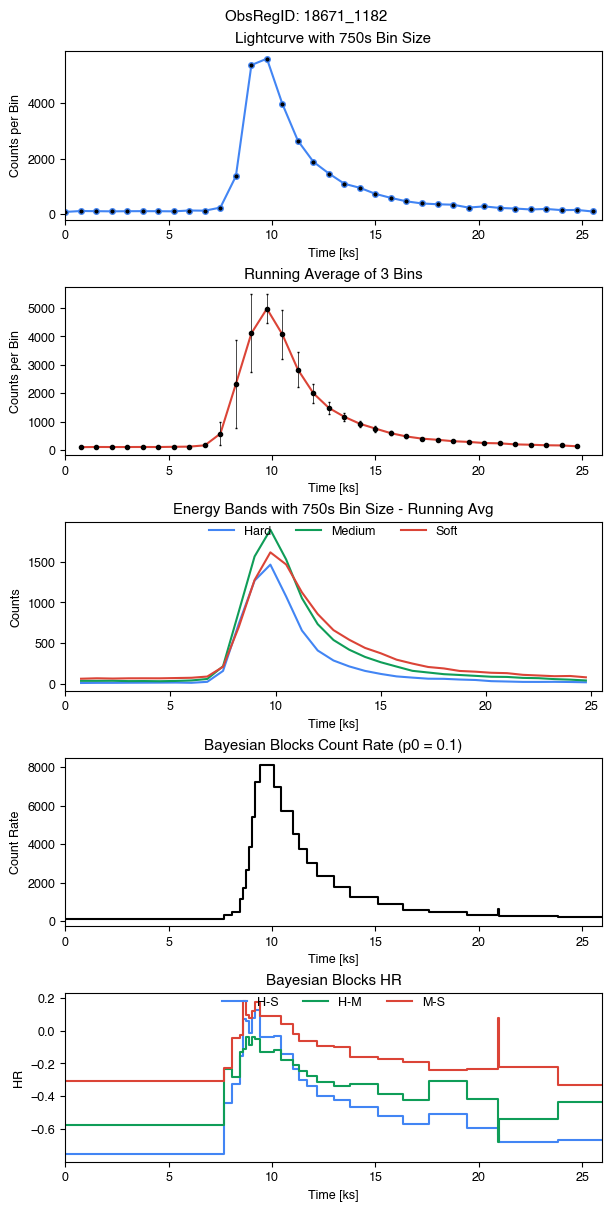

Name: 2CXO J053747.4-691019, ID: 1967-69, Date: 2000-12-07T19:42:26, Counts: 37622
RA  84.44743462203684 DEC  -69.17220150035753
varB  0.01 varH  0.1 varM  0.01 varS  0.02 varINDEX  0.0


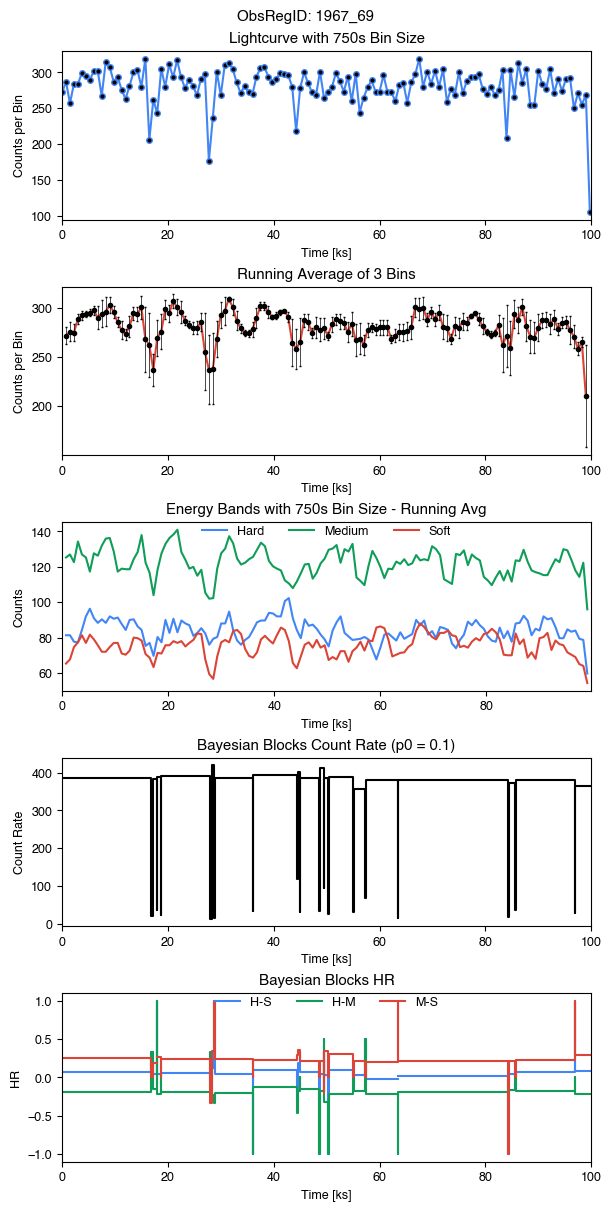

Name: 2CXO J225357.4+160857, ID: 4843-3, Date: 2004-08-04T05:19:42, Counts: 18054
RA  343.48944554750483 DEC  16.149178833418585
varB  0.92 varH  0.66 varM  0.27 varS  0.35 varINDEX  6.0


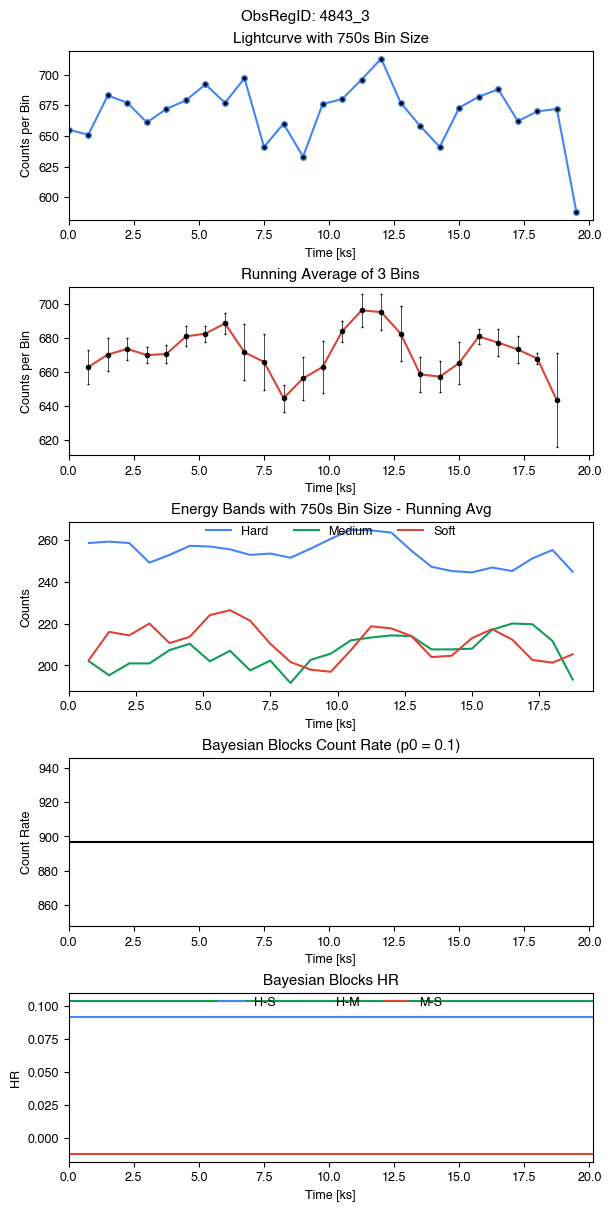

Name: 2CXO J083821.9+483803, ID: 6266-2, Date: 2005-06-05T14:16:15, Counts: 31983
RA  129.591562644928 DEC  48.63407156292483
varB  nan varH  0.99 varM  nan varS  nan varINDEX  nan


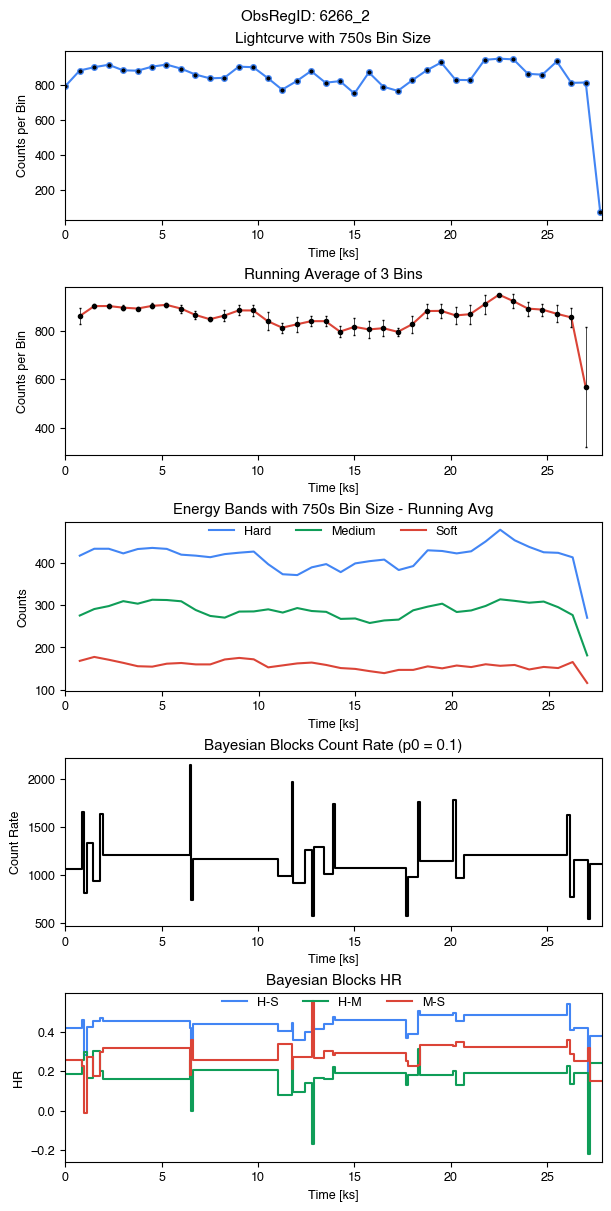

Name: 2CXO J161151.4-603755, ID: 9518-47, Date: 2008-06-13T13:37:34, Counts: 53885
RA  242.9641600903716 DEC  -60.63205078690258
varB  1.0 varH  1.0 varM  1.0 varS  1.0 varINDEX  10.0


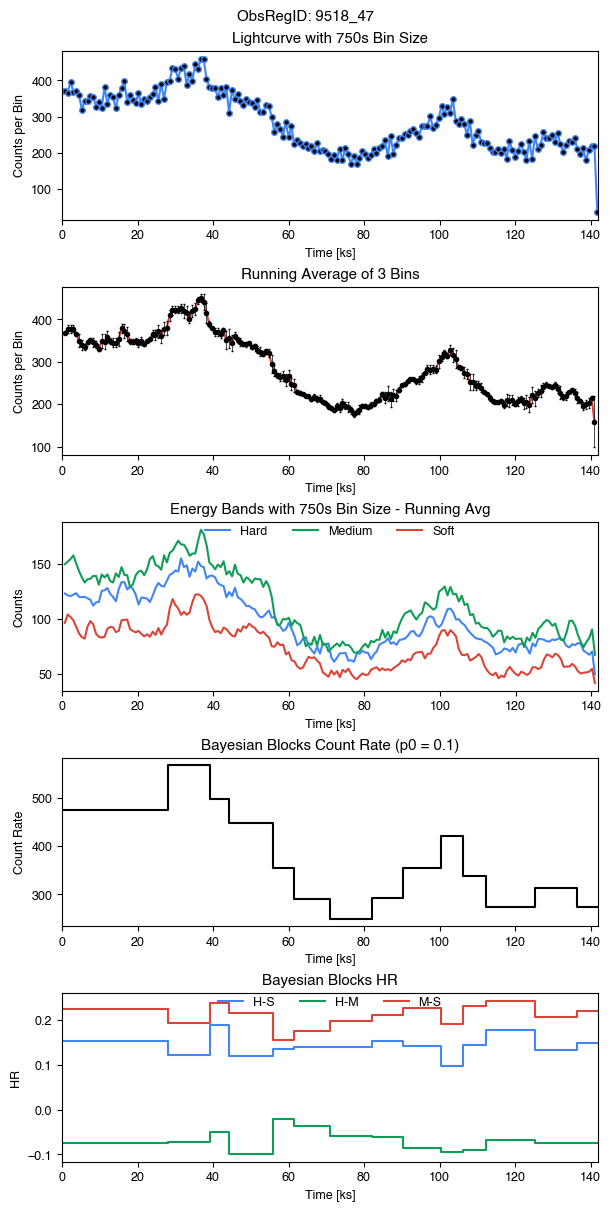

In [42]:
# ###
df_properties_anomalies = df_properties_anomalies2 # comment out for clusters
# df_select = points_in_box# comment out for clusters
# df_properties_anomalies = df_properties_anomalies[df_properties_anomalies['var_index_b']>0] #COMMENT OUT
potential_anomalies = df_properties_anomalies['obsreg_id']
# potential_anomalies = df_select['obsreg_id']
print(len(potential_anomalies))
keep = potential_anomalies.values[0:]


# keep = ['13814_86','2540_253','633_2117']
# keep = ['6442_37','11231_250','5424_145','16000_221']
# keep = ['3012_53','3744_830','4373_662','4396_2625','13117_169','13653_40','6291_253']
# keep = ['12330_2071','10135_343','11073_116','11073_116','13951_16']
# keep = potential_anomalies.values
# keep = ['9912_482']
years = range(1999,2023)
# Image producer
# keep = all_ids[50000:55000]
df_eventfiles_group_filtered = df_eventfiles_group.filter(lambda x: x.name in keep).groupby('obsreg_id')
for id_name, dfi in df_eventfiles_group_filtered:
    dfi.sort_values(by='time', inplace = True) 
    dfi.reset_index(drop=True, inplace = True)
    obsid = id_name.split("_")[0]
    regionid = id_name.split("_")[1]
    # Get property columns
    name = df_properties_anomalies[df_properties_anomalies['obsreg_id'] == id_name].name.values[0]
    ra = df_properties_anomalies[df_properties_anomalies['obsreg_id'] == id_name].ra.values[0]
    dec = df_properties_anomalies[df_properties_anomalies['obsreg_id'] == id_name].dec.values[0]
    date = df_properties_anomalies[df_properties_anomalies['obsreg_id'] == id_name].gti_obs.values[0] 
    var_prob_b = df_properties_anomalies[df_properties_anomalies['obsreg_id'] == id_name].var_prob_b.values[0]
    var_prob_h = df_properties_anomalies[df_properties_anomalies['obsreg_id'] == id_name].var_prob_h.values[0]
    var_prob_m = df_properties_anomalies[df_properties_anomalies['obsreg_id'] == id_name].var_prob_m.values[0]
    var_prob_s = df_properties_anomalies[df_properties_anomalies['obsreg_id'] == id_name].var_prob_s.values[0] 
    var_index_b = df_properties_anomalies[df_properties_anomalies['obsreg_id'] == id_name].var_index_b.values[0]

    if any(str(year) in date for year in years):
        print(f'Name: {name}, ID: {obsid}-{regionid}, Date: {date}, Counts: {len(dfi)}')
        print('RA ', str(ra), 'DEC ', str(dec))
        print('varB ', str(round(var_prob_b,2)), 'varH ', str(round(var_prob_h,2)),'varM ', str(round(var_prob_m,2)),'varS ', str(round(var_prob_s,2)),'varINDEX ', str(var_index_b))
        lightcurveplotterNEW(dfi,id_name,750,bb_p0=0.1,band_errors=False)
        # lightcurveplotterNEW(dfi,id_name,len(dfi)/100,bb_p0=0.1,band_errors=False)
    else:
        pass
    # # hist2D(dfi,id_name,16,24,'minmax',True,'plasma',lognorm=True)
    # # hist2D(dfi,id_name,16,24,'minmax',True,'plasma',lognorm=False)
    # hist3D(dfi,id_name,16,24,24,'minmax',True,'plasma',lognorm=True)
    #hist3D(dfi,id_name,16,24,24,'minmax',True,'plasma',lognorm=False)
    # hist3Dlog(dfi,id_name,16,24,24,'minmax',True,'plasma')